# **Process the dataset**

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
pip install -q --upgrade datasets==2.19.2


In [ ]:
from datasets import load_dataset
import pandas as pd, os

os.makedirs("dataset", exist_ok=True)

ds = load_dataset("NicolaiSivesind/human-vs-machine",
                  "research_abstracts_labeled")

pd.DataFrame(ds["train"]).to_csv("dataset/train.csv", index=False)
pd.DataFrame(ds["validation"]).to_csv("dataset/validation.csv", index=False)
pd.DataFrame(ds["test"]).to_csv("dataset/test.csv", index=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords", quiet=True)
stop_words = set(stopwords.words("english"))

def preprocess_text(text: str) -> str:
    """
    - lowercase
    - collapse whitespace
    - remove any char not in [a-z0-9 . , ! ? ; : ( ) ' -]
    - remove English stopwords
    """
    text = text.lower()
    text = re.sub(r"\s+", " ", text)

    text = re.sub(r"[^-a-z0-9.,!?;:()']", " ", text)

    tokens = text.split()
    filtered = [tok for tok in tokens if tok not in stop_words]
    return " ".join(filtered).strip()

df_train = pd.read_csv("dataset/train.csv")
df_val   = pd.read_csv("dataset/validation.csv")
df_test  = pd.read_csv("dataset/test.csv")

for df in (df_train, df_val, df_test):
    df["text"] = df["text"].apply(preprocess_text)

df_train.to_csv("dataset/train_preprocessed.csv",       index=False, encoding="utf-8")
df_val.to_csv("dataset/validation_preprocessed.csv", index=False, encoding="utf-8")
df_test.to_csv("dataset/test_preprocessed.csv",        index=False, encoding="utf-8")


# **FastText**

In [ ]:
import re
import pandas as pd

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9.,!?;:()\\-']", " ", text)
    return text.strip()

df_train = pd.read_csv("dataset/train_preprocessed.csv")
df_val   = pd.read_csv("dataset/validation_preprocessed.csv")
df_test  = pd.read_csv("dataset/test_preprocessed.csv")

df_train["label"] = df_train["label"].apply(lambda x: "__label__" + str(x))
df_val["label"]   = df_val["label"].apply(lambda x: "__label__" + str(x))

if "label" in df_test.columns:
    df_test["label"] = df_test["label"].apply(lambda x: "__label__" + str(x))

def save_fasttext_format(df, filename):
    df[["label", "text"]].to_csv(
        filename,
        index=False,
        sep=" ",
        header=False,
        quoting=3,
        escapechar="\\"
    )

save_fasttext_format(df_train, "fasttext/train.txt")
save_fasttext_format(df_val,   "fasttext/validation.txt")

df_test["text"].to_csv(
    "fasttext/test.txt",
    index=False,
    header=False,
    quoting=3,
    escapechar="\\"
)

if "label" in df_test.columns:
    df_test["label"].to_csv(
        "fasttext/test_answers.txt",
        index=False,
        header=False,
        quoting=3,
        escapechar="\\"
    )

def print_file_head(filename, n=10):
    print(f"First {n} lines of {filename}:")
    try:
        with open(filename, "r", encoding="utf-8") as f:
            for _ in range(n):
                line = f.readline()
                if not line:
                    break
                print(line.strip())
    except FileNotFoundError:
        print(f"File not found: {filename}")

print_file_head("fasttext/train.txt", n=10)
print()
print_file_head("fasttext/test.txt", n=10)
print()
if "label" in df_test.columns:
    print_file_head("fasttext/test_answers.txt", n=10)


First 10 lines of fasttext/train.txt:
__label__0 coupling\ losses\ studied\ composite\ tapes\ containing\ superconducting\ material\ form\ two\ separate\ stacks\ densely\ packed\ filaments\ embedded\ metallic\ matrix\ ag\ ag\ alloy.\ kind\ sample\ geometry\ quite\ favorable\ studying\ coupling\ currents\ particular\ role\ superconducting\ bridges\ filaments.\ using\ a.c.\ susceptibility\ technique,\ electromagnetic\ losses\ function\ a.c.\ magnetic\ field\ amplitude\ frequency\ measured\ temperature\ 77\ k\ two\ tapes\ different\ matrix\ composition.\ length\ samples\ varied\ subsequent\ cutting\ order\ investigate\ influence\ dynamics\ magnetic\ flux\ penetration.\ geometrical\ factor\ chi\ 0\ takes\ account\ demagnetizing\ effects\ established\ a.c.\ susceptibility\ data\ low\ amplitudes.\ losses\ vs\ frequency\ dependencies\ found\ agree\ nicely\ theoretical\ model\ developed\ round\ multifilamentary\ wires.\ applying\ model,\ effective\ resistivity\ matrix\ determined\ tape,\ using

In [ ]:
!pip uninstall -y fasttext
!pip install --no-cache-dir fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 200.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 282.6 MB/s eta 0:00:00
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313510 sha256=2beb8149abd95d24871f1d0a5a66503396de751c1b13ae85a600231d628368b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-5sqtgesw/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
import fasttext

model = fasttext.train_supervised(
    input="fasttext/train.txt",
    epoch=25,
    lr=0.5,
    wordNgrams=2,
    dim=100
)

model.save_model("fasttext/fasttext_model.bin")

print("validation:")
result = model.test("fasttext/validation.txt")
print(result)

print(f"Count: {result[0]}")
print(f"(Precision): {result[1]}")
print(f"(Recall): {result[2]}")

validation:
(3000, 0.9693333333333334, 0.9693333333333334)
Count: 3000
(Precision): 0.9693333333333334
(Recall): 0.9693333333333334


In [ ]:
import fasttext
import pandas as pd

model = fasttext.load_model("fasttext/fasttext_model.bin")

with open("fasttext/test.txt", "r", encoding="utf-8") as f:
    test_texts = [line.strip() for line in f if line.strip()]

df_test = pd.read_csv("dataset/test.csv", encoding="utf-8")
true_labels = df_test["label"].tolist()

if len(test_texts) != len(true_labels):
    print("Warning: number of lines in test.txt does not match test.csv labels!")

correct = 0
total = len(test_texts)
results = []

print("\nPredictions on test data:")

for i, text in enumerate(test_texts):
    labels, probabilities = model.predict(text, k=1)
    if not labels:
        predicted = "N/A"
    else:
        predicted = labels[0].replace("__label__", "")

    true_label = str(true_labels[i]) if i < len(true_labels) else "N/A"
    status = "OK" if predicted == true_label else "ERROR"
    if status == "OK":
        correct += 1

    results.append(f"Expected: {true_label}  Predicted: {predicted}  [{status}]")

accuracy = correct / total if total else 0.0
results.append(f"\nOverall accuracy: {accuracy*100:.2f}% ({correct}/{total})")

output_path = "fasttext/predictions.txt"
with open(output_path, "w", encoding="utf-8") as f:
    for line in results:
        f.write(line + "\n")

print(f"Results saved to {output_path}")



Predictions on test data:


ValueError: Unable to avoid copy while creating an array as requested.
If using `np.array(obj, copy=False)` replace it with `np.asarray(obj)` to allow a copy when needed (no behavior change in NumPy 1.x).
For more details, see https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword.

# **Deberta**

In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer, TFDebertaV2ForSequenceClassification

model_name = "microsoft/deberta-v3-base"
tokenizer   = AutoTokenizer.from_pretrained(model_name)
model       = TFDebertaV2ForSequenceClassification.from_pretrained(
                 model_name, num_labels=2)

df_train = pd.read_csv("dataset/train_preprocessed.csv")
df_val   = pd.read_csv("dataset/validation_preprocessed.csv")

train_texts  = df_train["text"].astype(str).tolist()
train_labels = df_train["label"].astype("int32").tolist()
val_texts    = df_val["text"].astype(str).tolist()
val_labels   = df_val["label"].astype("int32").tolist()

MAX_LEN = 512
train_enc = tokenizer(train_texts, truncation=True,
                      padding="max_length", max_length=MAX_LEN)
val_enc   = tokenizer(val_texts,   truncation=True,
                      padding="max_length", max_length=MAX_LEN)

def make_ds(encodings, labels):
    ds = tf.data.Dataset.from_tensor_slices((
        {k: tf.convert_to_tensor(v) for k, v in encodings.items()},
        tf.convert_to_tensor(labels)
    ))
    return ds

BATCH = 16
train_ds = make_ds(train_enc, train_labels).shuffle(len(train_texts)).batch(BATCH)
val_ds   = make_ds(val_enc,   val_labels).batch(BATCH)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

ep = 1
model.fit(train_ds, validation_data=val_ds, epochs=ep)

loss, acc = model.evaluate(val_ds)
print(f"\nValidation loss: {loss:.4f}")
print(f"Validation accuracy: {acc:.4f}")

model.save_pretrained("deberta/deberta_model")
tokenizer.save_pretrained("deberta/deberta_tokenizer")


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


tf_model.h5:   0%|          | 0.00/736M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

Some layers of TFDebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['cls_dropout', 'pooler', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


188/188 [==============================] - 25s 135ms/step - loss: 0.1276 - accuracy: 0.9630

Validation loss: 0.1276
Validation accuracy: 0.9630


('deberta/deberta_tokenizer/tokenizer_config.json',
 'deberta/deberta_tokenizer/special_tokens_map.json',
 'deberta/deberta_tokenizer/spm.model',
 'deberta/deberta_tokenizer/added_tokens.json',
 'deberta/deberta_tokenizer/tokenizer.json')

In [ ]:
import tensorflow as tf
import pandas as pd
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tqdm import tqdm

model_dir = "deberta/deberta_model"
tokenizer_dir = "deberta/deberta_tokenizer"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir)
model = TFAutoModelForSequenceClassification.from_pretrained(model_dir)

df_test = pd.read_csv("dataset/test_preprocessed.csv", encoding="utf-8")
test_texts = df_test["text"].tolist()
true_labels = df_test["label"].tolist()

predictions = []
for text in tqdm(test_texts, desc="Evaluating"):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    outputs = model(inputs)
    logits = outputs.logits
    predicted_label = tf.argmax(logits, axis=-1).numpy()[0]
    predictions.append(predicted_label)

results = []
correct_count = 0
total = len(predictions)

for i, pred in enumerate(predictions):
    true_label = true_labels[i]
    if pred == true_label:
        status = "✅"
        correct_count += 1
    else:
        status = "❌"
    results.append(f"Expected: {true_label}, Predicted: {pred} ({status})")

accuracy = correct_count / total if total > 0 else 0
results.append(f"\nOverall accuracy: {accuracy * 100:.2f}% ({correct_count}/{total})")

output_path = "results/deberta/deberta_3000.txt"
with open(output_path, "w", encoding="utf-8") as f:
    for line in results:
        f.write(line + "\n")

print(f"Results written to {output_path}")


All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

All the layers of TFDebertaV2ForSequenceClassification were initialized from the model checkpoint at deberta/deberta_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2ForSequenceClassification for predictions without further training.
Evaluating: 100%|██████████| 3000/3000 [18:24<00:00,  2.72it/s]

Results written to results/deberta/deberta_3000.txt


# **Mistral**

In [ ]:
!pip install transformers datasets accelerate bitsandbytes peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
!pip install -q --upgrade transformers

In [ ]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 29.8 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 2.19.2
    Uninstalling datasets-2.19.2:
      Successfully uninstalled datasets-2.19.2


In [ ]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from peft import LoraConfig, get_peft_model
from google.colab import files

train_df = pd.read_csv("dataset/train_preprocessed.csv")
val_df = pd.read_csv("dataset/validation_preprocessed.csv")

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

num_labels = len(train_df['label'].unique())

model_name = "mistralai/Mistral-7B-v0.1"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    trust_remote_code=True
)

if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.pad_token_id

lora_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=4,
    lora_alpha=32,
    lora_dropout=0.1
)
model = get_peft_model(model, lora_config)
print("LoRA applied. Trainable parameters:")
model.print_trainable_parameters()

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])

train_dataset.set_format("torch")
val_dataset.set_format("torch")

training_args = TrainingArguments(
    output_dir="./mistral",
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_dir='./logs',
    logging_steps=1,
    logging_strategy="steps",
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True,
    gradient_checkpointing=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("Starting fine-tuning...")
trainer.train()
print("Fine-tuning complete.")

test_csv = "dataset/test_preprocessed.csv"
if os.path.exists(test_csv):
    test_df = pd.read_csv(test_csv)
    test_dataset = Dataset.from_pandas(test_df)
    test_dataset = test_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.remove_columns(["text"])
    test_dataset.set_format("torch")

    predictions = trainer.predict(test_dataset)
    preds = predictions.predictions.argmax(-1)

    results_df = pd.DataFrame({
        "actual": test_df["label"],
        "predicted": preds
    })
    results_df.to_csv("test_results.csv", index=False, encoding="utf-8")
    print("Test results saved to test_results.csv")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at mistralai/Mistral-7B-v0.1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA applied. Trainable parameters:
trainable params: 1,712,128 || all params: 7,112,380,416 || trainable%: 0.0241


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Starting fine-tuning...


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Fine-tuning complete.


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Test results saved to test_results.csv


# **OpenChat**

In [ ]:
!pip install -U bitsandbytes

In [ ]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, BitsAndBytesConfig
from datasets import Dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from google.colab import files
import torch
import torch.nn as nn

train_df = pd.read_csv("dataset/train_preprocessed.csv")
val_df = pd.read_csv("dataset/validation_preprocessed.csv")

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
num_labels = len(train_df['label'].unique())

model_name = "openchat/openchat_3.5"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

class OpenChatClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
        )
        self.base = AutoModelForCausalLM.from_pretrained(
            model_name,
            trust_remote_code=True,
            quantization_config=bnb_config,
            device_map="auto"
        )
        self.base = prepare_model_for_kbit_training(self.base)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.base.config.hidden_size, num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.base.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )
        hidden = outputs.hidden_states[-1]
        cls_token = hidden[:, -1, :]
        logits = self.classifier(self.dropout(cls_token))

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))

        return {"loss": loss, "logits": logits}

model = OpenChatClassifier(model_name, num_labels)

lora_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"]
)
model.base = get_peft_model(model.base, lora_config)
print("LoRA parameters:")
model.base.print_trainable_parameters()

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")

training_args = TrainingArguments(
    output_dir="./openchat",
    num_train_epochs=3,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    logging_dir='./logs',
    logging_steps=1,
    logging_strategy="steps",
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("Start...")
trainer.train()
print("Finish...")


test_csv = "dataset/test_preprocessed.csv"
if os.path.exists(test_csv):
    test_df = pd.read_csv(test_csv)
    test_dataset = Dataset.from_pandas(test_df)
    test_dataset = test_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.remove_columns(["text"])
    test_dataset.set_format("torch")

    predictions = trainer.predict(test_dataset)
    preds = predictions.predictions.argmax(-1)

    results_df = pd.DataFrame({
        "actual": test_df["label"],
        "predicted": preds
    })
    results_df.to_csv("test_results.csv", index=False, encoding="utf-8")
    files.download("test_results.csv")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


LoRA parameters:
trainable params: 3,407,872 || all params: 7,245,156,352 || trainable%: 0.0470


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Start...


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Finish...


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Evaluate the result**

In [ ]:
import re
from pathlib import Path

SRC_ROOT = Path('results_local')
DST_ROOT = Path('results')

PATTERN = re.compile(r'.*?([01]).*?([01])')

MARKER_RE = re.compile(r'\(.*?Верно.*?\)|\(.*?Ошибка.*?\)')

NEW_TEMPLATE = "Expected: {exp} — Predicted: {pred}"

def transform_line(line: str) -> str | None:
    if not MARKER_RE.search(line):
        return None

    m = PATTERN.match(line)
    if not m:
        return None

    exp, pred = m.group(1), m.group(2)
    out = NEW_TEMPLATE.format(exp=exp, pred=pred)
    return re.sub(r'\(.*?\)', '', out).strip() + "\n"

def process_file(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    with src.open('r', encoding='utf-8') as fin, dst.open('w', encoding='utf-8') as fout:
        for line in fin:
            new_line = transform_line(line)
            if new_line:
                fout.write(new_line)

def main():
    for src_path in SRC_ROOT.rglob('*.txt'):
        rel = src_path.relative_to(SRC_ROOT)
        dst_path = DST_ROOT / rel
        process_file(src_path, dst_path)
        print(f"{src_path} → {dst_path}")

if __name__ == "__main__":
    main()


results_local/deberta/deberta_3000.txt → results/deberta/deberta_3000.txt


1) Accuracy vs Test Size
            Fasttext   Deberta   Mistral  Openchat
Test Size                                        
100        0.990000  0.990000  0.880000  0.970000
700        0.982857  0.990000  0.835714  0.974286
1500       0.986000  0.989333  0.826000  0.980667
3000       0.980667  0.988667  0.827000  0.980000


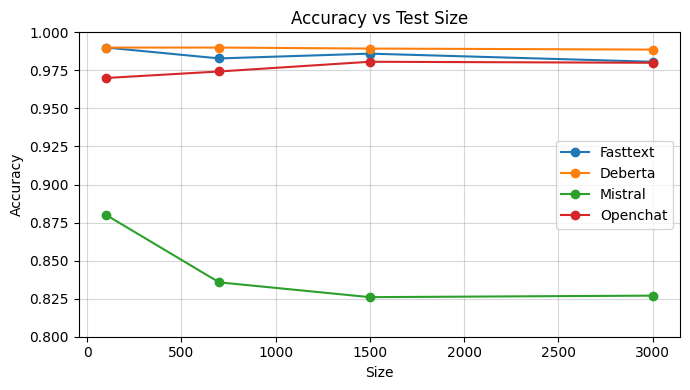


2) Summary @3000 samples
           Accuracy  Precision    Recall  F1-score
Model                                            
Fasttext  0.980667   0.980668  0.980667  0.980667
Deberta   0.988667   0.988667  0.988667  0.988667
Mistral   0.827000   0.827221  0.827000  0.826971
Openchat  0.980000   0.980031  0.980000  0.980000


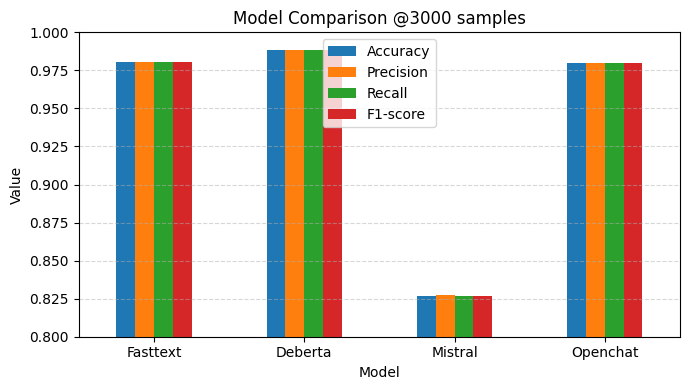


-------------------------------------------------------------

             --- Detailed report for Fasttext ---

-------------------------------------------------------------
              precision    recall  f1-score   support

       human       0.98      0.98      0.98      1500
     machine       0.98      0.98      0.98      1500

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



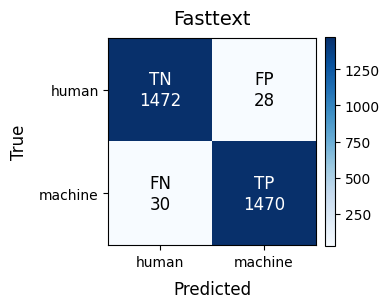


-------------------------------------------------------------

             --- Detailed report for Deberta ---

-------------------------------------------------------------
              precision    recall  f1-score   support

       human       0.99      0.99      0.99      1500
     machine       0.99      0.99      0.99      1500

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



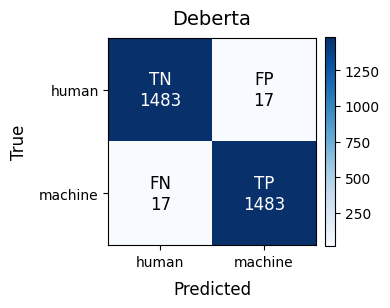


-------------------------------------------------------------

             --- Detailed report for Mistral ---

-------------------------------------------------------------
              precision    recall  f1-score   support

       human       0.82      0.84      0.83      1500
     machine       0.84      0.81      0.82      1500

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



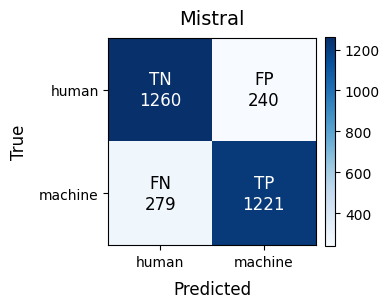


-------------------------------------------------------------

             --- Detailed report for Openchat ---

-------------------------------------------------------------
              precision    recall  f1-score   support

       human       0.98      0.98      0.98      1500
     machine       0.98      0.98      0.98      1500

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



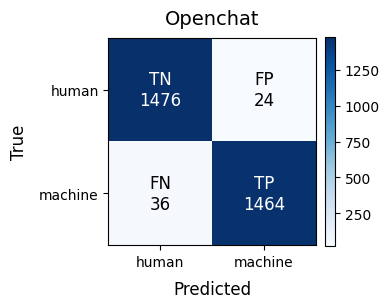

In [ ]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

BASE = Path('results')
MODELS = ['fasttext','deberta','mistral','openchat']
SIZES  = [100,700,1500,3000]
PATTERN = re.compile(r'Expected:\s*([01])\s*—\s*Predicted:\s*([01])')

data = {}
for m in MODELS:
    data[m] = {}
    for s in SIZES:
        y_true, y_pred = [], []
        path = BASE/m/f"{m}_{s}.txt"
        if path.exists():
            for line in path.read_text('utf-8').splitlines():
                mo = PATTERN.search(line)
                if mo:
                    y_true.append(int(mo[1]))
                    y_pred.append(int(mo[2]))
        data[m][s] = (np.array(y_true), np.array(y_pred))

acc_df = pd.DataFrame({
    m.capitalize(): [accuracy_score(*data[m][s]) for s in SIZES]
    for m in MODELS
}, index=SIZES)
acc_df.index.name = 'Test Size'
print("1) Accuracy vs Test Size\n", acc_df)

plt.figure(figsize=(7,4))
for col in acc_df.columns:
    plt.plot(acc_df.index, acc_df[col], marker='o', label=col)
plt.title('Accuracy vs Test Size')
plt.xlabel('Size')
plt.ylabel('Accuracy')
plt.ylim(0.80, 1.00)
plt.grid('--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

rows = []
for m in MODELS:
    y_t, y_p = data[m][3000]
    if y_t.size == 0:
        print(f"[!] No data for {m}@3000 — skipping.")
        continue
    rows.append({
        'Model':    m.capitalize(),
        'Accuracy': accuracy_score(y_t, y_p),
        'Precision': precision_score(y_t, y_p, average='macro', zero_division=0),
        'Recall':    recall_score(y_t, y_p, average='macro', zero_division=0),
        'F1-score':  f1_score(y_t, y_p, average='macro', zero_division=0),
    })
summary_df = pd.DataFrame(rows).set_index('Model')
print("\n2) Summary @3000 samples\n", summary_df)

ax = summary_df.plot.bar(figsize=(7,4), rot=0)
ax.set_title('Model Comparison @3000 samples')
ax.set_ylabel('Value')
ax.set_ylim(0.80, 1.00)
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

def plot_cm_counts(y_t, y_p, name):
    cm = confusion_matrix(y_t, y_p, labels=[0,1])
    tags = {(0,0):'TN',(0,1):'FP',(1,0):'FN',(1,1):'TP'}
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap='Blues')
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, f"{tags[(i,j)]}\n{v}",
                ha='center', va='center',
                color='white' if v>cm.max()/2 else 'black',
                fontsize=12)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['human','machine'], fontsize=10)
    ax.set_yticklabels(['human','machine'], fontsize=10)
    ax.set_xlabel('Predicted', labelpad=8, fontsize=12)
    ax.set_ylabel('True',      labelpad=8, fontsize=12)
    ax.set_title(f'{name}', pad=10, fontsize=14)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

for m in MODELS:
    y_t, y_p = data[m][3000]
    if y_t.size == 0:
        continue
    print(f"\n-------------------------------------------------------------")
    print(f"\n             --- Detailed report for {m.capitalize()} ---")
    print(f"\n-------------------------------------------------------------")
    print(classification_report(
        y_t, y_p,
        labels=[0,1],
        target_names=['human','machine'],
        zero_division=0
    ))
    plot_cm_counts(y_t, y_p, m.capitalize())


In [ ]:
import re
from pathlib import Path
import numpy as np
import pandas as pd

df = pd.read_csv('dataset/train.csv')
df = df.reset_index().rename(columns={'index':'dataset_index'})
test_df = df.iloc[:3000].copy()

MODELS = ['fasttext','deberta','mistral','openchat']
PAT    = re.compile(r'Expected:\s*([01])\s*—\s*Predicted:\s*([01])')

preds = {}
for m in MODELS:
    fn = Path('results')/m/f"{m}_3000.txt"
    y_pred = []
    with fn.open(encoding='utf-8') as f:
        for line in f:
            mo = PAT.search(line)
            if mo:
                y_pred.append(int(mo[2]))
    preds[m] = pd.Series(y_pred, name=f"{m}_pred")

combined = test_df[['dataset_index','text','label']].copy()
combined.rename(columns={'label':'true_label'}, inplace=True)
for m in MODELS:
    combined[f"{m}_pred"] = preds[m].values

mask = np.all([combined[f"{m}_pred"] != combined['true_label'] for m in MODELS], axis=0)
hard_cases = combined.loc[mask].reset_index(drop=True)

print(f"\nNumber of examples all models misclassified: {len(hard_cases)}\n")
print(hard_cases.to_string(index=False))

hard_cases.to_csv('hard_cases_all_models_wrong.csv', index=False)



Number of examples all models misclassified: 4

 dataset_index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         